<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 15525, '日付': '2022-02-15T08:00:00.000Z'},
 {'小計': 17331, '日付': '2022-02-16T08:00:00.000Z'},
 {'小計': 17864, '日付': '2022-02-17T08:00:00.000Z'},
 {'小計': 16129, '日付': '2022-02-18T08:00:00.000Z'},
 {'小計': 13516, '日付': '2022-02-19T08:00:00.000Z'},
 {'小計': 12935, '日付': '2022-02-20T08:00:00.000Z'},
 {'小計': 8805, '日付': '2022-02-21T08:00:00.000Z'},
 {'小計': 11443, '日付': '2022-02-22T08:00:00.000Z'},
 {'小計': 14567, '日付': '2022-02-23T08:00:00.000Z'},
 {'小計': 10169, '日付': '2022-02-24T08:00:00.000Z'},
 {'小計': 11125, '日付': '2022-02-25T08:00:00.000Z'},
 {'小計': 11562, '日付': '2022-02-26T08:00:00.000Z'},
 {'小計': 10321, '日付': '2022-02-27T08:00:00.000Z'},
 {'小計': 9632, '日付': '2022-02-28T08:00:00.000Z'},
 {'小計': 11813, '日付': '2022-03-01T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-02-25 17:00:00+09:00,946,0,11125,2022-02-25 17:00:00+09:00
2022-02-26 17:00:00+09:00,1070,0,11562,2022-02-26 17:00:00+09:00
2022-02-27 17:00:00+09:00,939,0,10321,2022-02-27 17:00:00+09:00
2022-02-28 17:00:00+09:00,1013,0,9632,2022-02-28 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-02-25 17:00:00+09:00,946,0,11125,2022-02-25 17:00:00+09:00,1115.714286,7810.0,0.0,0.0,11794.285714,82560.0
2022-02-26 17:00:00+09:00,1070,0,11562,2022-02-26 17:00:00+09:00,1083.857143,7587.0,0.0,0.0,11515.142857,80606.0
2022-02-27 17:00:00+09:00,939,0,10321,2022-02-27 17:00:00+09:00,1066.428571,7465.0,0.0,0.0,11141.714286,77992.0
2022-02-28 17:00:00+09:00,1013,0,9632,2022-02-28 17:00:00+09:00,1022.428571,7157.0,0.0,0.0,11259.857143,78819.0
2022-03-01 17:00:00+09:00,0,0,11813,2022-03-01 17:00:00+09:00,871.571429,6101.0,0.0,0.0,11312.714286,79189.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-02-15 17:00:00+09:00,1356,0,15525,2022-02-15 17:00:00+09:00,1602.285714,11216.0,0.0,0.0,15219.428571,106536.0,'22w07,Tue
2022-02-16 17:00:00+09:00,1300,0,17331,2022-02-16 17:00:00+09:00,1554.285714,10880.0,0.0,0.0,15082.857143,105580.0,'22w07,Wed
2022-02-17 17:00:00+09:00,1206,0,17864,2022-02-17 17:00:00+09:00,1507.000000,10549.0,0.0,0.0,14936.142857,104553.0,'22w07,Thu
2022-02-18 17:00:00+09:00,1129,0,16129,2022-02-18 17:00:00+09:00,1417.285714,9921.0,0.0,0.0,14574.571429,102022.0,'22w07,Fri
2022-02-19 17:00:00+09:00,1293,0,13516,2022-02-19 17:00:00+09:00,1347.000000,9429.0,0.0,0.0,14824.714286,103773.0,'22w07,Sat
2022-02-20 17:00:00+09:00,1061,0,12935,2022-02-20 17:00:00+09:00,1300.714286,9105.0,0.0,0.0,14804.857143,103634.0,'22w07,Sun
2022-02-21 17:00:00+09:00,1321,0,8805,2022-02-21 17:00:00+09:00,1238.000000,8666.0,0.0,0.0,14586.428571,102105.0,'22w08,Mon
2022-02-22 17:00:00+09:00,1056,0,11443,2022-02-22 17:00:00+09:00,1195.142857,8366.0,0.0,0.0,14003.285714,98023.0,'22w08,Tue
2022-02-23 17:00:00+09:00,1109,0,14567,2022-02-23 17:00:00+09:00,1167.857143,8175.0,0.0,0.0,13608.428571,95259.0,'22w08,Wed
2022-02-24 17:00:00+09:00,1024,0,10169,2022-02-24 17:00:00+09:00,1141.857143,7993.0,0.0,0.0,12509.142857,87564.0,'22w08,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-02-13 17:00:00+09:00,15714.428571,110001
2022-02-20 17:00:00+09:00,14804.857143,103634
2022-02-27 17:00:00+09:00,11141.714286,77992
2022-03-01 17:00:00+09:00,10722.500000,21445
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-02-15 17:00:00+09:00,1356,0,15525,2022-02-15 17:00:00+09:00,1602.285714,11216.0,0.0,0.0,15219.428571,106536.0,'22w07,Tue,NaN,NaN
2022-02-16 17:00:00+09:00,1300,0,17331,2022-02-16 17:00:00+09:00,1554.285714,10880.0,0.0,0.0,15082.857143,105580.0,'22w07,Wed,NaN,NaN
2022-02-17 17:00:00+09:00,1206,0,17864,2022-02-17 17:00:00+09:00,1507.000000,10549.0,0.0,0.0,14936.142857,104553.0,'22w07,Thu,NaN,NaN
2022-02-18 17:00:00+09:00,1129,0,16129,2022-02-18 17:00:00+09:00,1417.285714,9921.0,0.0,0.0,14574.571429,102022.0,'22w07,Fri,NaN,NaN
2022-02-19 17:00:00+09:00,1293,0,13516,2022-02-19 17:00:00+09:00,1347.000000,9429.0,0.0,0.0,14824.714286,103773.0,'22w07,Sat,NaN,NaN
2022-02-20 17:00:00+09:00,1061,0,12935,2022-02-20 17:00:00+09:00,1300.714286,9105.0,0.0,0.0,14804.857143,103634.0,'22w07,Sun,14804.857143,103634.0
2022-02-21 17:00:00+09:00,1321,0,8805,2022-02-21 17:00:00+09:00,1238.000000,8666.0,0.0,0.0,14586.428571,102105.0,'22w08,Mon,NaN,NaN
2022-02-22 17:00:00+09:00,1056,0,11443,2022-02-22 17:00:00+09:00,1195.142857,8366.0,0.0,0.0,14003.285714,98023.0,'22w08,Tue,NaN,NaN
2022-02-23 17:00:00+09:00,1109,0,14567,2022-02-23 17:00:00+09:00,1167.857143,8175.0,0.0,0.0,13608.428571,95259.0,'22w08,Wed,NaN,NaN
2022-02-24 17:00:00+09:00,1024,0,10169,2022-02-24 17:00:00+09:00,1141.857143,7993.0,0.0,0.0,12509.142857,87564.0,'22w08,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

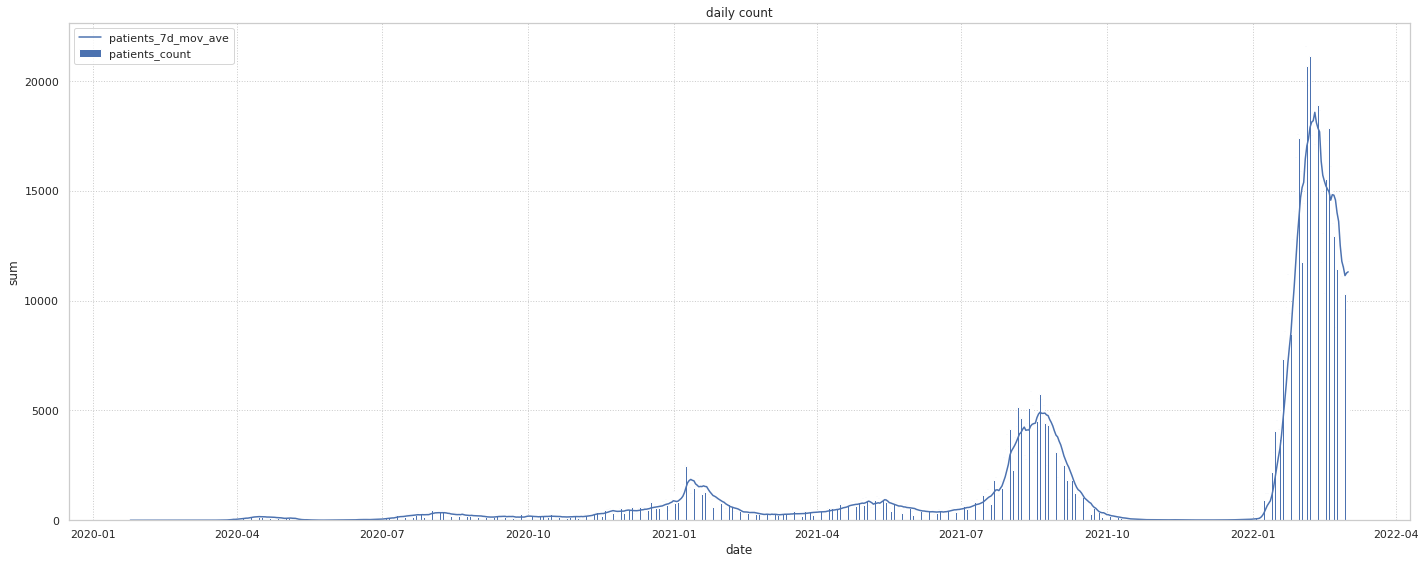

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
753,1.644912e+09,2022,2,15,0,0,0,0,0,1,0,753,0,679,1356,1602.285714,11216.0,0,0.0,0.0,15525,15219.428571,106536.0
754,1.644998e+09,2022,2,16,0,0,0,0,0,0,1,754,0,680,1300,1554.285714,10880.0,0,0.0,0.0,17331,15082.857143,105580.0
755,1.645085e+09,2022,2,17,0,0,0,0,1,0,0,755,0,681,1206,1507.000000,10549.0,0,0.0,0.0,17864,14936.142857,104553.0
756,1.645171e+09,2022,2,18,1,0,0,0,0,0,0,756,0,682,1129,1417.285714,9921.0,0,0.0,0.0,16129,14574.571429,102022.0
757,1.645258e+09,2022,2,19,0,0,1,0,0,0,0,757,0,683,1293,1347.000000,9429.0,0,0.0,0.0,13516,14824.714286,103773.0
758,1.645344e+09,2022,2,20,0,0,0,1,0,0,0,758,0,684,1061,1300.714286,9105.0,0,0.0,0.0,12935,14804.857143,103634.0
759,1.645430e+09,2022,2,21,0,1,0,0,0,0,0,759,0,685,1321,1238.000000,8666.0,0,0.0,0.0,8805,14586.428571,102105.0
760,1.645517e+09,2022,2,22,0,0,0,0,0,1,0,760,0,686,1056,1195.142857,8366.0,0,0.0,0.0,11443,14003.285714,98023.0
761,1.645603e+09,2022,2,23,0,0,0,0,0,0,1,761,0,687,1109,1167.857143,8175.0,0,0.0,0.0,14567,13608.428571,95259.0
762,1.645690e+09,2022,2,24,0,0,0,0,1,0,0,762,0,688,1024,1141.857143,7993.0,0,0.0,0.0,10169,12509.142857,87564.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            768 non-null    float64
 1   year                 768 non-null    int64  
 2   month                768 non-null    int64  
 3   day                  768 non-null    int64  
 4   Fri                  768 non-null    uint8  
 5   Mon                  768 non-null    uint8  
 6   Sat                  768 non-null    uint8  
 7   Sun                  768 non-null    uint8  
 8   Thu                  768 non-null    uint8  
 9   Tue                  768 non-null    uint8  
 10  Wed                  768 non-null    uint8  
 11  passed               768 non-null    int64  
 12  emergency            768 non-null    int64  
 13  em_passed            768 non-null    int64  
 14  contacts_count       768 non-null    int64  
 15  contacts_7d_mov_ave  768 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.680000e+02,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,1.612987e+09,2020.631510,6.292969,15.796875,0.143229,0.143229,0.143229,0.143229,0.141927,0.143229,0.141927,383.500000,0.063802,313.113281,688.375000,685.595393,4799.162760,479.842448,479.842448,3358.897135,1309.688802,1267.387705,8871.692708
std,1.916756e+07,0.624069,3.516970,8.836654,0.350535,0.350535,0.350535,0.350535,0.349203,0.350535,0.349203,221.846794,0.244559,216.295392,565.422893,552.943629,3870.611567,785.090138,720.985249,5046.896740,3335.796425,3212.830322,22489.820631
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.596420e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,191.750000,0.000000,117.750000,326.000000,325.250000,2276.750000,0.000000,0.000000,0.000000,54.000000,52.821429,369.750000
50%,1.612987e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,383.500000,0.000000,309.500000,510.000000,513.357143,3593.500000,0.000000,0.000000,0.000000,258.500000,269.214286,1884.500000
75%,1.629554e+09,2021.000000,9.000000,23.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,575.250000,0.000000,501.250000,872.250000,885.785714,6200.500000,961.000000,1041.464286,7290.250000,700.500000,688.964286,4822.750000
max,1.646122e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,767.000000,1.000000,693.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21576.000000,18575.000000,130025.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.886412,0.183147,0.009252,-0.003688,0.001844,-0.001844,-3.104774e-16,0.000917,0.003688,-0.000917,1.000000e+00,-0.336178,0.998585,-0.020933,-0.013307,-0.013305,-0.618772,-0.664777,-0.664777,0.458582,0.458701,0.458702
year,8.864115e-01,1.000000,-0.291125,-0.027776,-0.002778,0.003182,0.003182,3.181732e-03,-0.004993,0.003182,-0.004993,8.864115e-01,-0.264341,0.892235,0.109446,0.116650,0.116651,-0.619288,-0.674351,-0.674351,0.584394,0.579853,0.579854
month,1.831468e-01,-0.291125,1.000000,-0.004082,-0.002355,-0.003412,-0.010815,-7.642523e-03,0.012810,0.001876,0.009625,1.831468e-01,-0.132416,0.167704,-0.278648,-0.277062,-0.277060,0.037112,0.059945,0.059945,-0.296800,-0.286726,-0.286724
day,9.251709e-03,-0.027776,-0.004082,1.000000,0.007721,0.005616,0.002249,1.024645e-02,-0.003321,-0.011641,-0.010926,9.251709e-03,-0.003045,0.009973,0.025252,0.010179,0.010178,0.002509,-0.008336,-0.008336,0.011070,0.008189,0.008188
Fri,-3.688444e-03,-0.002778,-0.002355,0.007721,1.000000,-0.167173,-0.167173,-1.671733e-01,-0.166285,-0.167173,-0.166285,-3.688444e-03,-0.000277,-0.003241,-0.015250,-0.002170,-0.002170,0.025201,-0.000707,-0.000707,0.017204,-0.002211,-0.002212
Mon,1.844222e-03,0.003182,-0.003412,0.005616,-0.167173,1.000000,-0.167173,-1.671733e-01,-0.166285,-0.167173,-0.166285,1.844222e-03,-0.000277,0.001866,0.038763,0.000734,0.000734,0.101560,-0.000707,-0.000707,-0.049217,0.003000,0.003000
Sat,-1.844222e-03,0.003182,-0.010815,0.002249,-0.167173,-0.167173,1.000000,-1.671733e-01,-0.166285,-0.167173,-0.166285,-1.844222e-03,-0.000277,-0.001538,0.043565,-0.001142,-0.001141,-0.118632,-0.000707,-0.000707,0.011145,-0.000299,-0.000300
Sun,-3.104774e-16,0.003182,-0.007643,0.010246,-0.167173,-0.167173,-0.167173,1.000000e+00,-0.166285,-0.167173,-0.166285,-3.109218e-16,-0.000277,0.000164,-0.022630,-0.000240,-0.000239,-0.109351,-0.000707,-0.000707,-0.010943,0.001407,0.001407
Thu,9.172132e-04,-0.004993,0.012810,-0.003321,-0.166285,-0.166285,-0.166285,-1.662853e-01,1.000000,-0.166285,-0.165402,9.172132e-04,0.000696,0.000443,-0.010287,0.001538,0.001539,0.031564,0.001775,0.001775,0.022557,-0.002595,-0.002594
Tue,3.688444e-03,0.003182,0.001876,-0.011641,-0.167173,-0.167173,-0.167173,-1.671733e-01,-0.166285,1.000000,-0.166285,3.688444e-03,-0.000277,0.003569,-0.021920,0.000734,0.000734,0.040129,-0.000707,-0.000707,-0.004779,0.004954,0.004954


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.645776e+09,1,0,0,0,0,0,0,763,0,689,946,0,11125,11794.285714,82560.0
764,1.645862e+09,0,0,1,0,0,0,0,764,0,690,1070,0,11562,11515.142857,80606.0
765,1.645949e+09,0,0,0,1,0,0,0,765,0,691,939,0,10321,11141.714286,77992.0
766,1.646035e+09,0,1,0,0,0,0,0,766,0,692,1013,0,9632,11259.857143,78819.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
763,1.645776e+09,763,0,11125,11794.285714,82560.0
764,1.645862e+09,764,0,11562,11515.142857,80606.0
765,1.645949e+09,765,0,10321,11141.714286,77992.0
766,1.646035e+09,766,0,9632,11259.857143,78819.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

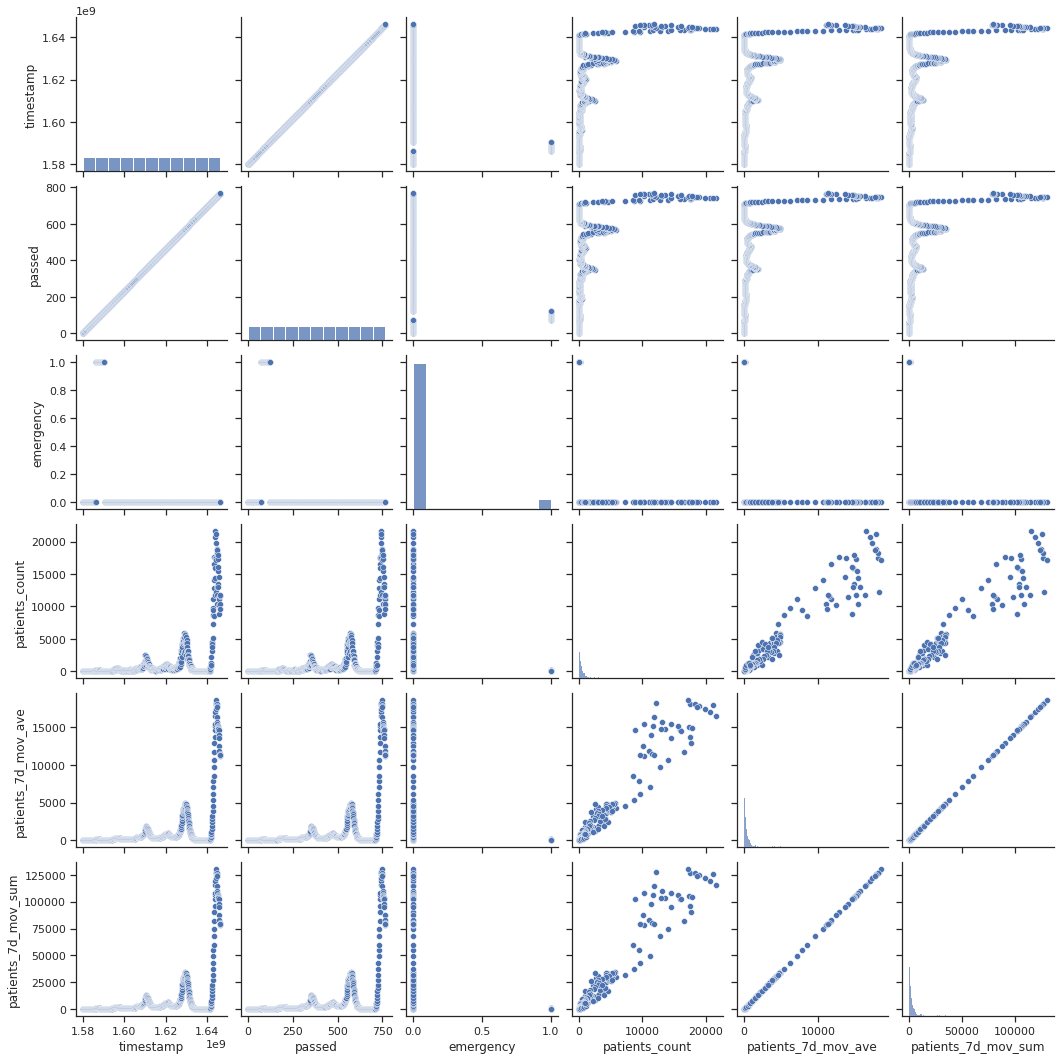

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==